In [1]:
%%capture
!pip install stanza

In [3]:
import urllib.parse, urllib.request, json, sys
import stanza

In [4]:
STD_API = "https://cadhan.com/api/intergaelic/3.0"

def standardise(text: str, lang: str = "ga"):
    """Return a list of (orig_tok, std_tok) pairs from Intergaelic."""
    data   = urllib.parse.urlencode({"foinse": lang, "teacs": text}).encode()
    hdrs   = {"Content-Type": "application/x-www-form-urlencoded",
              "Accept":        "application/json"}
    req    = urllib.request.Request(STD_API, data, hdrs)
    with urllib.request.urlopen(req) as resp:
        return json.loads(resp.read())

In [5]:
stanza.download("ga", processors="tokenize,pos,lemma,depparse", verbose=False)

nlp = stanza.Pipeline(
    lang="ga",
    processors="tokenize,pos,lemma,depparse",
    # Let Stanza decide sentences & tokens
    tokenize_pretokenized=True,
    no_ssplit=True,
    verbose=False
)

In [6]:
from itertools import groupby
from typing import List, Tuple

def _split_std(std: str, orig: str) -> List[str]:
    """Return the token(s) that should feed Stanza for this pair."""
    if not std.strip():
        return [orig]
    return std.split()

def _sentences_from_pairs(pairs: List[Tuple[str, str]]):
    """Very light sentence splitter: keep everything up to . ! ?"""
    sent, buf = [], []
    for i, (orig, std) in enumerate(pairs):
        parts = _split_std(std, orig)
        for j, part in enumerate(parts):
            buf.append((i, j, len(parts), orig, part))
            if part in {".", "!", "?"}:
                sent.append(buf);  buf = []
    if buf:
        sent.append(buf)
    return sent

def project_with_stanza(raw_text: str, lang: str = "ga") -> str:
    pairs  = standardise(raw_text, lang)

    sents  = _sentences_from_pairs(pairs)
    pretok = [[m[4] for m in sent] for sent in sents]

    doc = nlp(pretok)

    conllu_lines = []
    for sid, (sent_map, sent_doc) in enumerate(zip(sents, doc.sentences), 1):
        raw_slice = [m[3] for m in sent_map if m[1] == 0]
        std_slice = [m[4] for m in sent_map]
        conllu_lines += [
            f"# sent_id = {sid}",
            f"# text = {' '.join(raw_slice)}",
            f"# text_standard = {' '.join(std_slice)}",
        ]

        # token lines
        widx = 0
        tid  = 1
        for m in sent_map:
            orig_i, sub_i, n_sub, orig_tok, std_tok = m
            word = sent_doc.words[widx]

            if sub_i == 0 and n_sub > 1:
                conllu_lines.append(f"{tid}-{tid+n_sub-1}\t{orig_tok}\t_\t_\t_\t_\t_\t_\t_\t_")

            form = orig_tok if n_sub == 1 else std_tok

            conllu_lines.append("\t".join([
                str(tid),
                form,
                word.lemma or "_",
                word.upos  or "_",
                word.xpos  or "_",
                word.feats or "_",
                str(word.head) if word.head else "_",
                word.deprel or "_",
                "_",
                "_",
            ]))

            widx += 1
            tid  += 1
        conllu_lines.append("")

    return "\n".join(conllu_lines)


In [7]:
PAGE = """Maidin amháin, chuaigh gamal as Gúra amach chun
connadh a bhailiú. Shiúil sé leis thar an machaire gur tháinig
sé go dtí crann mór ológ cois abhann.

Dhreap sé an crann agus shuigh sé faoi ar an ngéag ba mhó ar
an gcrann. Nuair a bhraith sé ar a shocracht ar an ngéag,
thosaigh sé á bualadh le tua.

Ghabh an sagart thar bráid. D'fhéach sé in airde agus labhair
leis an ngamal:

"A dheartháirín ó, cad atá ar bun agat?" ar sé os ard. "Ní mar
sin a ghearrtar adhmad!"

"Níl aon bhealach eile ann, a Athair," arsa an gamal.
"Caithfear an tua a ardú agus é a bhualadh anuas ar an
adhmad!"

"Ach tá tú i do shuí ar an ngéag atá á gearradh agat! Brisfidh
an ghéag, agus nuair a bhrisfidh titfidh tusa go talamh agus
marófar thú,” arsa an sagart.
"""

In [11]:
paras = [x.replace("\n", " ") for x in PAGE.split("\n\n")]

In [12]:
paras

['Maidin amháin, chuaigh gamal as Gúra amach chun connadh a bhailiú. Shiúil sé leis thar an machaire gur tháinig sé go dtí crann mór ológ cois abhann.',
 'Dhreap sé an crann agus shuigh sé faoi ar an ngéag ba mhó ar an gcrann. Nuair a bhraith sé ar a shocracht ar an ngéag, thosaigh sé á bualadh le tua.',
 "Ghabh an sagart thar bráid. D'fhéach sé in airde agus labhair leis an ngamal:",
 '"A dheartháirín ó, cad atá ar bun agat?" ar sé os ard. "Ní mar sin a ghearrtar adhmad!"',
 '"Níl aon bhealach eile ann, a Athair," arsa an gamal. "Caithfear an tua a ardú agus é a bhualadh anuas ar an adhmad!"',
 '"Ach tá tú i do shuí ar an ngéag atá á gearradh agat! Brisfidh an ghéag, agus nuair a bhrisfidh titfidh tusa go talamh agus marófar thú,” arsa an sagart. ']

In [7]:
nlp_tok = stanza.Pipeline(
    lang="ga",
    processors="tokenize,pos,lemma,depparse",
    tokenize_pretokenized=False,
    verbose=False
)

In [21]:
pp = project_with_stanza("E-, ‘firing range’ a mbíonns acub agus é seo agus é siúd.")

In [22]:
print(pp)

# sent_id = 1
# text = E - , ‘ firing range ’ a mbíonns acub agus é seo agus é siúd .
# text_standard = É - , ‘ firing range ’ a mbíonn acu agus é seo agus é siúd .
1	E	é	PRON	Pers	Gender=Masc|Number=Sing|Person=3	_	root	_	_
2	-	-	PUNCT	.	_	4	punct	_	_
3	,	,	PUNCT	Punct	_	4	punct	_	_
4	‘	‘	X	Foreign	Foreign=Yes	1	parataxis	_	_
5	firing	firing	X	Foreign	Foreign=Yes	4	flat:foreign	_	_
6	range	range	X	Foreign	Foreign=Yes	4	flat:foreign	_	_
7	’	’	PUNCT	Punct	_	9	punct	_	_
8	a	a	PART	Vb	Form=Indirect|PartType=Vb|PronType=Rel	9	mark:prt	_	_
9	mbíonns	bí	VERB	PresImp	Aspect=Hab|Form=Ecl|Mood=Ind|Tense=Pres	4	acl:relcl	_	_
10	acub	ag	ADP	Prep	Number=Plur|Person=3	9	obl:prep	_	_
11	agus	agus	CCONJ	Coord	_	12	cc	_	_
12	é	é	PRON	Pers	Gender=Masc|Number=Sing|Person=3	1	conj	_	_
13	seo	seo	PRON	Dem	PronType=Dem	12	det	_	_
14	agus	agus	SCONJ	Subord	_	15	mark	_	_
15	é	é	PRON	Pers	Gender=Masc|Number=Sing|Person=3	12	conj	_	_
16	siúd	siúd	PRON	Dem	PronType=Dem	15	det	_	_
17	.	.	PUNCT	.	_	1	punct	_	_



In [2]:
raw = """
        Críoch
      """

In [11]:
lines = "{:C}".format(nlp_tok(raw)).split("\n")
print("\n".join(lines))

# text = Críoch
# sent_id = 0
1	Críoch	críoch	NOUN	Noun	Case=Nom|Gender=Fem|Number=Sing	0	root	_	start_char=9|end_char=15|SpacesAfter=\n\s\s\s\s\s\s|SpacesBefore=\n\s\s\s\s\s\s\s\s


In [12]:
!pip install pytesseract opencv-python-headless

In [19]:
!sudo apt install tesseract-ocr tesseract-ocr-gle

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  tesseract-ocr-gle
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 613 kB of archives.
After this operation, 1,197 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-gle all 1:4.00~git30-7274cfa-1.1 [613 kB]
Fetched 613 kB in 2s (350 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting p

In [36]:
import requests
import numpy as np
import os

def read_image_from_url(url):
    response = requests.get(url)
    image_array = np.frombuffer(response.content, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return image

In [24]:
import pytesseract
import cv2

def extract_text_from_bbox(image_path, bbox, lang="gle"):
    image = cv2.imread(image_path)

    # Extract the region of interest
    x1, y1, x2, y2 = bbox
    roi = image[y1:y2, x1:x2]

    # Convert the ROI to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    text = pytesseract.image_to_string(gray, lang=lang)

    return text

In [67]:
import pytesseract
import cv2
from IPython.display import display, Image
import io

def extract_text_from_bbox_and_url(url, bbox, lang="gle"):
    image = read_image_from_url(url)

    # Extract the region of interest
    x1, y1, x2, y2 = bbox
    roi = image[y1:y2, x1:x2]

    # Convert the ROI to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    _, buffer = cv2.imencode('.png', roi)
    io_buf = io.BytesIO(buffer)
    display(Image(io_buf.getvalue()))

    text = pytesseract.image_to_string(gray, lang=lang)

    return text

In [39]:
import requests
from bs4 import BeautifulSoup

def get_image_selector_from_url(url, selector):
    req = requests.get(url)
    assert req.status_code == 200, f"Failed to fetch {url}"
    soup = BeautifulSoup(req.text, 'html.parser')
    element = soup.select_one(selector)
    if element:
        return element['src']
    else:
        return None

In [106]:
def get_image_from_data(url, selector, bbox_text):
    bbox = [int(x) for x in bbox_text.split(" ")]
    img = get_image_selector_from_url(url, selector)
    return extract_text_from_bbox_and_url(img, bbox)

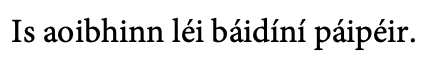

In [107]:
b = get_image_from_data("https://www.leighleat.com/pages/1803", "#ajax-page-container > div > div:nth-child(2) > img", "297 681 725 742")

In [108]:
lines = "{:C}".format(nlp_tok(b)).split("\n")
print("\n".join(lines))

# text = Is aoibhinn léi báidíní páipéir.
# sent_id = 0
1	Is	is	AUX	Cop	Tense=Pres|VerbForm=Cop	2	cop	_	start_char=0|end_char=2
2	aoibhinn	aoibhinn	ADJ	Adj	Degree=Pos	0	root	_	start_char=3|end_char=11
3	léi	le	ADP	Prep	Gender=Fem|Number=Sing|Person=3	2	obl:prep	_	start_char=12|end_char=15
4	báidíní	báid	NOUN	Noun	Case=Nom|Gender=Masc|Number=Plur	2	nsubj	_	start_char=16|end_char=23
5	páipéir	páipéar	NOUN	Noun	Case=Gen|Gender=Masc|Number=Sing	4	nmod	_	start_char=24|end_char=31|SpaceAfter=No
6	.	.	PUNCT	.	_	2	punct	_	start_char=31|end_char=32|SpacesAfter=\n


In [89]:
cor = "Nuair a thagann Brídín abhaile, ordaíonn a mamaí di í féin a ghlanadh."
lines = "{:C}".format(nlp_tok(cor)).split("\n")
print("\n".join(lines))

# text = Nuair a thagann Brídín abhaile, ordaíonn a mamaí di í féin a ghlanadh.
# sent_id = 0
1	Nuair	nuair	SCONJ	Subord	_	3	mark	_	start_char=0|end_char=5
2	a	a	PART	Vb	Form=Direct|PartType=Vb|PronType=Rel	3	mark:prt	_	start_char=6|end_char=7
3	thagann	tar	VERB	PresInd	Form=Len|Mood=Ind|Tense=Pres	7	advcl	_	start_char=8|end_char=15
4	Brídín	Brídín	PROPN	Noun	Definite=Def|Gender=Fem|Number=Sing	3	nsubj	_	start_char=16|end_char=22
5	abhaile	abhaile	ADV	Dir	_	3	advmod	_	start_char=23|end_char=30|SpaceAfter=No
6	,	,	PUNCT	Punct	_	7	punct	_	start_char=30|end_char=31
7	ordaíonn	ordaigh	VERB	VTI	Mood=Ind|Tense=Pres	0	root	_	start_char=32|end_char=40
8	a	a	DET	Det	Gender=Masc|Number=Sing|Person=3|Poss=Yes	9	nmod:poss	_	start_char=41|end_char=42
9	mamaí	mamaí	NOUN	Noun	Case=Nom|Definite=Def|Gender=Masc|Number=Sing	7	nsubj	_	start_char=43|end_char=48
10	di	do	ADP	Prep	Gender=Fem|Number=Sing|Person=3	7	obl:prep	_	start_char=49|end_char=51
11	í	í	PRON	Pers	Gender=Fem|Number=Sing|Person=3	14	obj	_

In [100]:
b[71:76]

'Bíonn'